In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [7]:
#NV in (0, -1) subspace
sz_e = (sigmaz()-qeye(2))*0.5
sz = tensor(sz_e, qeye(2),qeye(3))
sx = tensor(sigmax()*0.5, qeye(2),qeye(3))
sy = tensor(sigmay()*0.5, qeye(2),qeye(3))

#13C is spin 1/2
iz = tensor(qeye(2), sigmaz()*0.5,qeye(3))
ix = tensor(qeye(2), sigmax()*0.5,qeye(3))

niz = tensor(qeye(2), qeye(2),spin_Jz(1))
#del(s_z)
niz

Quantum object: dims = [[2, 2, 3], [2, 2, 3]], shape = (12, 12), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]]

In [3]:
gamma = 10.7*1e-4
B = 7/gamma
B

6542.056074766355

In [33]:
class NV:
    def __init__(self, c13_zz=0.09,c13_zx=0.046,B=6500,delta=0,Omega=10,N=60):
        self.C13_zz = c13_zz
        self.C13_zx = c13_zx
        self.B = B

        self.Delta = delta *2*np.pi
        self.Omega = Omega *2*np.pi
        self.N = N
        self.fid = 0.0689
        gamma_n = 10.7*1e-4 # MHz/G
        self.H0 = iz*gamma_n*self.B*2*np.pi + 2*np.pi*sz*iz*self.C13_zz + 2*np.pi*sz*ix*self.C13_zx
   

    def update_h0(self):
        gamma_n = 10.7*1e-4 # MHz/G
        self.H0 = iz*gamma_n*self.B*2*np.pi + 2*np.pi*sz*iz*self.C13_zz + 2*np.pi*sz*ix*self.C13_zx
        self.H0 += 2.18 * 2 * np.pi * sz * niz + 6 * 2 * np.pi * niz
    def get_h_fid(self):
        
        self.Hfid = self.H0 + self.Delta * sz
        return self.Hfid
    
    def get_h_pulse(self,phi=0):
        Hpulse =  self.H0 + self.Delta * sz+ self.Omega * (np.cos(np.deg2rad(phi)) * sx + np.sin(np.deg2rad(phi)) * sy)
        return Hpulse
    
    def get_unitaries(self,fid=0.100):
        electron_pi = 0.05 #mus 
        fid_time = fid - electron_pi
        if fid_time < 0: return 
        
        self.Upi2x = (self.get_h_pulse(phi=0)*1j*electron_pi*0.5).expm()
        #self.Upi2mx = (self.get_h_pulse(phi=180)*1j*electron_pi*0.5).expm()
        self.Upi2y = (self.get_h_pulse(phi=90)*1j*electron_pi*0.5).expm()
        #self.Upi2my = (self.get_h_pulse(phi=270)*1j*electron_pi*0.5).expm()
        self.Upix = (self.get_h_pulse(phi=0)*1j*electron_pi).expm()
        self.Upiy = (self.get_h_pulse(phi=90)*1j*electron_pi).expm()
        self.Ufid = (self.get_h_fid()*1j*fid_time * 0.5).expm()
        
        
    def get_sequence(self,fid = 0.10000):
        
        self.get_unitaries(fid=fid)

        Us = []
        for k in range(self.N):
            for i in range(2):
                if i%2==0:
                    Us.append(self.Upi2x)
                else:
                    Us.append(self.Upi2y)
                    
                for j in range(4):
                    Us.append(self.Ufid)
                    if j%2 == 0:
                        Us.append(self.Upix)
                    else:
                        Us.append(self.Upiy)
                    Us.append(self.Ufid)
                if i%2==0:
                    Us.append(self.Upi2x)
                else:
                    Us.append(self.Upi2y)
        self.seq = Us 
        return Us
    
    def evolve(self, rho, seq):        
        rho1 = rho
        rho_list = []
        for s in seq:
            if isinstance(s, Qobj):
                rho1 = s*rho1*s.dag()
            elif isinstance(s, float):
                U = (self.H[i]*1j*s).expm()
                rho1 = U*rho1*U.dag()
            elif isinstance(s, dict):
                out = mesolve(rho0=rho1, H=self.H, c_ops=[tensor(sigmaz(),qeye(2))], tlist=np.linspace(0,s['T_c'], 10), 
                          options = Options(nsteps=1e5))
                return out.states[-1]
            rho_list.append(rho1)
        return rho1, rho_list
    
    def experiment(self):
        Pi = 1
        rho = tensor(fock_dm(2,0), qeye(2)*0.5,qeye(3)/3.0)#fock_dm(3,1))
        self.update_h0()
        self.get_sequence(fid = self.fid)
        rho1,rho_list = self.evolve(rho, self.seq)
        rho_list.insert(0,rho)
        return rho1,rho_list
    
   
    
    
    
#create random bath:
#C13_zz_b = np.random.normal(loc = 0, scale =0.15, size=5)#[0.13, 0.13,0.1, 0.04,0.002,0.05, 0.1]
#C13_zx_b = np.random.normal(loc=0,scale=0.15, size=5)

#add two known spins to it
#C13_zz = np.array([-200.73436071,52.2228743806])*1e-3
#C13_zx = np.array([73.365909271,143.61522982])*1e-3
#C13_zz = np.append(C13_zz, C13_zz_b)
#C13_zx = np.append(C13_zx, C13_zx_b)

#add two known spins to it
#C13_zz = np.array([52.2228743806])*1e-3
#C13_zx = np.array([143.61522982])*1e-3
#C13_zz = np.append(C13_zz, C13_zz_b)
#C13_zx = np.append(C13_zx, C13_zx_b)

mynv = NV()



In [27]:
rho1,rho_list = mynv.experiment()

0.0039059721008401216


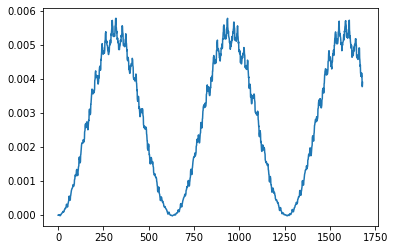

In [34]:
def get_expectation(rho_list,op = sx):
    expectation = []
    for j, rho in enumerate(rho_list):
        expectation.append(expect(rho, op))
    return expectation

#plt.plot(get_expectation(rho_list,sz))
plt.plot(get_expectation(rho_list,iz))

expectation = get_expectation(rho_list,iz)
print(expectation[-1])

0
20
40


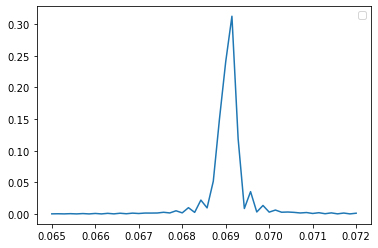

In [35]:
tau_fids = np.linspace(0.065,0.072,50)
detection = []
for i, tau_fid in enumerate(tau_fids):
    if i%20==0: print(i)
    mynv.fid = tau_fid
    mynv.Delta = 0
    mynv.N = 60
    rho1,rho_list = mynv.experiment()
    detection.append(get_expectation([rho1],iz)[-1])
plt.plot(tau_fids,detection)
plt.legend()

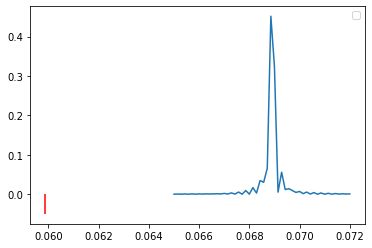

In [31]:
plt.plot(tau_fids,detection)
plt.vlines(0.05988,-0.05,0.,color='red')
plt.legend()

In [32]:
deltas = np.linspace(-5,5,100)
fids = np.linspace(0.068,0.0695,50)
detection = []
full_evolution = np.zeros((len(deltas),1681)) #1681 = len(rho_list)

for i, delta in enumerate(deltas):
    if i%20==0: print(i)
    mynv = NV()
    mynv.fid =  0.0689
    mynv.Delta = delta * 2 * np.pi
    mynv.N = 60
    rho1,rho_list = mynv.experiment()
    detection.append(get_expectation([rho1],iz)[-1])
    full_evolution[i] = get_expectation(rho_list,iz)
#plt.plot(tau_fids,detection)
#plt.legend()

0
20
40
60
80


In [36]:
deltas = np.linspace(-5,5,31)
fids = np.linspace(0.0684,0.07,31)
detection = []

detection2d = np.zeros((len(fids),len(deltas)))

for j, fid in enumerate(fids):
    print(j)
    for i, delta in enumerate(deltas):
        #if i%20==0: print(i)
        mynv = NV()
        mynv.fid =  fid
        mynv.Delta = delta * 2 * np.pi
        mynv.N = 60
        rho1,rho_list = mynv.experiment()
        detection.append(get_expectation([rho1],iz)[-1])
        detection2d[j][i] = get_expectation([rho1],iz)[-1]
        #full_evolution[i] = get_expectation(rho_list,iz)
#plt.plot(tau_fids,detection)
#plt.legend()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


<ipython-input-37-49fe788ce838>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX,YY,detection2d)


(31, 31)
(31, 31)


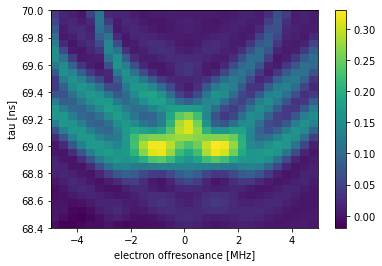

In [37]:
X = np.asarray(fids)*1000
Y = np.asarray(deltas)
XX,YY = np.meshgrid(Y,X)
plt.pcolormesh(XX,YY,detection2d)
plt.xlabel('electron offresonance [MHz]')
plt.ylabel('tau [ns]')
plt.savefig('2d-tau-off-resonance.png',dpi=120)
plt.colorbar()
print(detection2d.shape)
print(YY.shape)

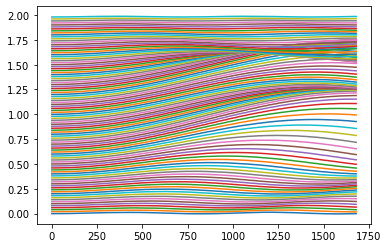

In [75]:
for i, evolution in enumerate(full_evolution[:100]):
    plt.plot(evolution + 0.02 * i)
plt.show()

TypeError: Dimensions of C (100, 1681) are incompatible with X (1681) and/or Y (10); see help(pcolormesh)

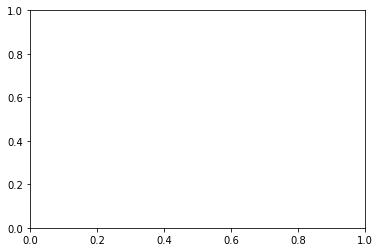

In [85]:
fig,ax = plt.subplots()
X = np.asarray(deltas)
Y = np.arange(len(rho_list))
XX,YY = np.meshgrid(Y,X)
plt.pcolormesh(XX,YY,full_evolution)
plt.xlabel('time arb. units')
plt.ylabel('offresonance [MHz]')
plt.colorbar()
plt.tight_layout()
plt.savefig('offresonance-time-evolution-05.png',dpi=120)
#ax.set_yticks(deltas)

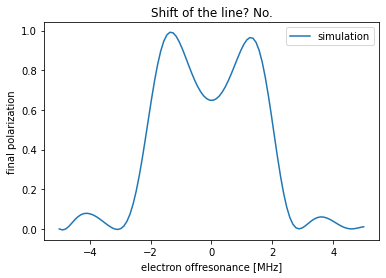

In [74]:
plt.plot(deltas,np.asarray(detection)/0.5,label = 'simulation')
plt.xlabel('electron offresonance [MHz]')
plt.ylabel('final polarization')
plt.legend()
plt.title('Shift of the line?')
plt.savefig('off-resonance-shift',dpi=120)